In [3]:
import numpy as np
from numpy import sin, cos
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# car parameters
car_l = 4.3
car_w = 1.8


# car corners
base_corners = np.array([
    [ car_l / 2, -car_w / 2, 0], # front right
    [-car_l / 2, -car_w / 2, 0], # rear right
    [-car_l / 2,  car_w / 2, 0],  # rear left
    [ car_l / 2,  car_w / 2, 0], # front left
])

def plot_car(pos):
    rotated_corners = R.from_euler('xyz', [0,0,pos[2]]).apply(base_corners)
    rotated_corners += pos[:]

    plt.plot(rotated_corners[:, 0], rotated_corners[:, 1])
    plt.plot(pos[0], pos[1], 'ro')

def set_eq():
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.grid(visible=True)



/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
def plot_traj(traj, include_car=False, car_step=5, cutoff=-1):
    set_eq()
    color_size = len(traj[:cutoff])
    x = traj[:cutoff, 0]
    y = traj[:cutoff, 1]

    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    plt.xlim(xmin - 5, xmax + 5)
    plt.ylim(ymin - 5, ymax + 5)

    color = np.arange(0, color_size)
    plt.scatter(x, y, c=color, cmap='rainbow', linewidths=2, marker='d', s=0.05)

    if include_car:
        for car_point in traj[::car_step]:
            plot_car(car_point)


In [5]:
import pickle

def unpack_data(data):
    times = np.zeros(len(data))
    values = np.zeros((len(data), len(data[0][0])), dtype=np.float32)
    for idx in range(len(data)):
        times[idx] = data[idx][1]
        values[idx] = data[idx][0]

    return values, times

def load_data(filename):
    with open(filename, 'rb') as in_file:
        data = pickle.load(in_file)
    pos_val, pos_times = unpack_data(data['pos'])
    vel_val, vel_times = unpack_data(data['vel'])
    control_val, control_times = unpack_data(data['control'])
    control_val = np.concat(([[0, 0]], control_val))
    control_times = np.concat(([pos_times[0]], control_times))


    return (pos_val, pos_times), (vel_val, vel_times), (control_val, control_times)

In [6]:
def control_to_accel( u):
    m_c = 1500
    r = 0.3
    m_w = 11
    J_w = 1 /2 * m_w * r**2
    max_torque = 19.78
    a_c = max_torque * u / (
        (m_c + 4 * m_w) * r +
        4 * J_w / r
    )
    return a_c

def next_model_step(cur_pos:np.ndarray, cur_velocity:float, control_inputs:np.ndarray, dt:float):
    x_i, y_i, phi_i = cur_pos
    v_i = cur_velocity # R.from_euler('xyz', [0, 0, phi_i]).apply(cur_velocity)[0]
    u1 = control_inputs[0] # max torque percentage. 
    u2 = control_inputs[1] # steering wheel angle
    u2 = np.clip(u2, -0.6, 0.6)

    # friction losses
    k_friction = 0.05  # losses due to turns
    drag_coefficient = 0.00  # linear drag losses

    # 1) update velocity
    accel = control_to_accel(u1)
    lateral_loss = k_friction * abs(np.tan(u2)) * v_i**2  
    drag_loss = np.abs(drag_coefficient * v_i)  

    # make sure losses are always against velocity
    lateral_loss *= -np.sign(accel)
    drag_loss *= -np.sign(accel)

    next_vel = v_i + (accel + lateral_loss + drag_loss) * dt

    # 2) update angle
    lf = 2.3 # distance from center mass to front axle

    next_angular_vel = v_i * np.tan(u2) / lf * 0.5

    next_phi = phi_i + next_angular_vel * dt

    # make sure angle is between 0 and 2 pi
    next_phi = next_phi % (np.pi * 2)

    # 3) update GLOBAL position
    next_x = x_i + v_i * cos(phi_i) * dt
    next_y = y_i + v_i * sin(phi_i) * dt

    return np.array([next_x, next_y, next_phi]), next_vel, next_angular_vel

def predict_path(x0, v0, control_val, control_times, dt=0.1):
    control_val = np.array(control_val)
    control_times = np.array(control_times)
    poses = [x0]
    vels = [v0]
    cur_pose = x0
    cur_vel = v0

    times = [control_times[0]]
    controls = [control_val[0]]
    cumtime = control_times[0]
    for control_idx in range(len(control_times) - 1):
        while cumtime < control_times[control_idx + 1]:
            cur_pose, cur_vel, _ = next_model_step(cur_pose, cur_vel, control_val[control_idx], dt)
            poses.append(cur_pose)
            vels.append(cur_vel)
            controls.append(control_val[control_idx])
            cumtime += dt
            times.append(cumtime)

    

    return np.array(poses), np.array(vels),  np.array(controls), np.array(times) 

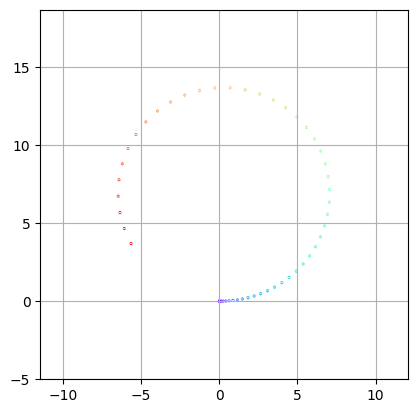

In [7]:
n_steps = 50
time_horizon = 5
p, _, _, times = predict_path(
    x0=np.zeros((3,)), 
    v0=0, 
    control_val=np.ones((n_steps,2)) * 100, 
    control_times=np.linspace(0, time_horizon, n_steps), 
    dt=time_horizon/n_steps
    )
plot_traj(p)

In [8]:
def list_derivative(values, times):
    dtimes = times[1:] - times[-1]
    dvalues = values[1:] - values[:-1]
    return dvalues / dtimes, times[:-1]

def plot_with_time_cutoff(data, times, min_t=-1, max_t=None):
    min_cutoff = times > min_t
    if max_t is not None:
        max_cutoff = times < max_t
    else:
        max_cutoff = min_cutoff
    
    total_cutoff = min_cutoff * max_cutoff

    for plot in data:
        plt.plot(times[total_cutoff], plot[total_cutoff])

In [9]:
def comparison_pipeline(log_file):
    (pos_val, pos_times), (vel_val, vel_times), (control_val, control_times) = load_data(log_file)
    pos_val[:, 2] = pos_val[:, 2] % (2 * np.pi)
    ang_vel = vel_val[:, 2]
    vel_val = vel_val[:, 0]
    control_val = np.concat(([[0, 0]], control_val))
    control_times = np.concat(([0], control_times))
    
    step = 100
    full_pred = []
    full_pred_t = []
    full_pred_ang = []
    for i in range(0, len(pos_val) - step, step):
        time_selection = (control_times > pos_times[i]) * (control_times < pos_times[i + step])
        if time_selection.any():
            ct = control_times[time_selection]
            ct = np.concatenate((ct, [pos_times[i + step - 1]]))
    
            cv = control_val[time_selection]
            cv = np.concatenate((cv, [control_val[time_selection][-1]]))
            p_pos, p_vel, controls, times = predict_path(
                x0=pos_val[i], 
                v0=vel_val[i], 
                control_val=cv, 
                control_times=ct
                )
            full_pred.extend(p_pos)
            full_pred_t.extend(times)
    
    
    full_pred = np.array(full_pred)
    plot_traj(pos_val)
    plt.plot(full_pred[:, 0], full_pred[:, 1], 'b--')
    plt.show()
    

In [10]:
log_file = '\
logs/data_26.893105268478394.pkl'
comparison_pipeline(log_file)
log_file = '\
logs/data_35.71177363395691.pkl'
comparison_pipeline(log_file)
log_file = '\
logs/data_36.06831669807434.pkl'
comparison_pipeline(log_file)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/data_26.893105268478394.pkl'

# MPC MOCKUP

In [80]:
from copy import copy
import numpy as np
from scipy.optimize import minimize
from time import time

class basic_mpc():

    def __init__(self):
        # MPC PARAMETERS
        self.n_steps = 30 # mpc prediction steps
        self.desired_velocity = 0.5 # velocity that car should be moving with
        self.lookahead = 4 # distance that mpc optimizes on
        self.interp_dx = 0.25

        # error costs
        self.Q = np.array([
            [1., 0],
            [0,   1]
        ]) * 50
        # control costs
        self.R = np.array([
                [0.5, 0],
                [0, 0.1]

            ])

        self.max_torque_percent = 10
        self.max_wheel_angle = 0.6
        self.u1_bounds = np.array([-self.max_torque_percent, self.max_torque_percent]) # torque bounds
        self.u2_bounds = np.array([-self.max_wheel_angle, self.max_wheel_angle]) # steer bounds

    def control_to_accel(self, u):
        m_c = 1500
        r = 0.3
        m_w = 11
        J_w = 1 /2 * m_w * r**2

        max_torque = 19.78
        a_c = max_torque * u / (
            (m_c + 4 * m_w) * r +
            4 * J_w / r
        )

        return a_c

    def next_model_step(self, cur_pos:np.ndarray, cur_velocity:float, control_inputs:np.ndarray, dt:float):
        x_i, y_i, phi_i = cur_pos
        v_i = cur_velocity # R.from_euler('xyz', [0, 0, phi_i]).apply(cur_velocity)[0]
        u1 = control_inputs[0] # max torque percentage. 
        u2 = control_inputs[1] # steering wheel angle
        u2 = np.clip(u2, -0.6, 0.6)

        # friction losses
        k_friction = 0.05  # losses due to turns
        drag_coefficient = 0.00  # linear drag losses

        # 1) update velocity
        accel = self.control_to_accel(u1)
        lateral_loss = k_friction * abs(np.tan(u2)) * v_i**2  
        drag_loss = np.abs(drag_coefficient * v_i)  

        # make sure losses are always against velocity
        lateral_loss *= -np.sign(accel)
        drag_loss *= -np.sign(accel)

        next_vel = v_i + (accel + lateral_loss + drag_loss) * dt

        # 2) update angle
        lf = 2.3 # distance from center mass to front axle

        next_angular_vel = v_i * np.tan(u2) / lf * 0.5

        next_phi = phi_i + next_angular_vel * dt

        # make sure angle is between 0 and 2 pi
        next_phi = next_phi % (np.pi * 2)

        # 3) update GLOBAL position
        next_x = x_i + v_i * cos(phi_i) * dt
        next_y = y_i + v_i * sin(phi_i) * dt

        return np.array([next_x, next_y, next_phi]), next_vel, next_angular_vel

    def xte(self, point_a, point_b, pos):
        ab = point_b - point_a
        ap = pos - point_a
        if ab[0] == 0 and ab[1] == 0:
            return np.linalg.norm(ap)
        return np.abs(ab[0] * ap[1] - ab[1] * ap[0]) / np.linalg.norm(ab)
    
    def angle_error(self, phi_i, phi_d):
        d1 = np.abs(phi_d - phi_i)
        d2 = np.pi * 2 - d1
        return min(d1, d2)
    
    def normalize_control(self, u):
        return np.array([
            u[0] / self.max_torque_percent,
            u[1] / self.max_wheel_angle
            ]
        )

    def predict_and_cost(self, u, x0, v0, ref_traj, n_steps, dt, return_pred=False):
        """Predicts trajectory based on initial state step by step and
           calculates the cost of given control u.

        Args:
            u (np.ndarray): FLATTENED Controls to be evaluated. 
            x0 (np.ndarray): initial x, y, phi.
            v0 (np.ndarray): intial forward velocity
            ref_traj (np.ndarray): Array of points of desired x, y, phi
            n_steps (int): Prediction horizon in steps.
            dt (float): Prediction discrete time.
        Returns:
            float: cost of given trajectory
        """
        cur_pose = x0
        cur_vel = v0
        cost = 0
        time_elapsed = 0

        if return_pred:
            predictions = []

        for step_i in range(n_steps):
            # get current controls
            u_i = u[step_i*2:(step_i + 1) * 2]

            # get next step
            cur_pose, cur_vel, _ = self.next_model_step(
                cur_pos=cur_pose,
                cur_velocity=cur_vel,
                control_inputs=u_i,
                dt = dt
            )

            if return_pred:
                predictions.append(copy(cur_pose))
            
            time_elapsed += dt
            falloff = 1 # np.exp(-time_elapsed/3)
            
            # split pose into position and orientation
            pos = cur_pose[:2]
            phi = cur_pose[2]

            # get ref points
            point_a = ref_traj[step_i]
            point_b = ref_traj[min(step_i+1, len(ref_traj) - 1)]

            # calculate errors
            xte_error = self.xte(point_a[:2], point_b[:2], pos)
            angle_error = self.angle_error(phi, ref_traj[step_i, 2])
            # normalize xte
            xte_error /= self.lookahead
            # normalize angle error
            angle_error = angle_error / np.pi


            # calculate error cost
            state_error = np.array([xte_error, angle_error])
            cost += state_error.T @ self.Q @ state_error * falloff

            # calculate control cost
            u_i = u[step_i*2:(step_i+1)*2]
            norm_u_i = self.normalize_control(u_i)
            cost += norm_u_i.T @ self.R @ norm_u_i * falloff

            # punish for not going with desired speed
            # calculate diff to desired vel
            vel_error = cur_vel - self.desired_velocity
            cost += vel_error**2 * falloff

        if return_pred:
            return cost, predictions

        return cost

    def time(self):
        return time()

    def optimize_control_MPC(self, x0, v0, ref_traj):

        # self.publish_traj(ref_traj)
        
        u0 = np.ones(2 * self.n_steps) 
        # u0[::2] = 10
        u0[1::2] = 0.3 * np.sign(ref_traj[0,2] - x0[2])

        # create constraints 
        bounds = np.ones((self.n_steps * 2, 2), dtype=np.float32) 
        # and fill them with current bounds
        bounds[::2] = self.u1_bounds
        bounds[1::2] = self.u2_bounds
        
        # minimize cost
        opt_start = self.time()
        result = minimize(
                fun=lambda u: self.predict_and_cost(
                u=u,
                x0=x0,
                v0=v0,
                ref_traj=ref_traj,
                n_steps=self.n_steps,
                dt=(self.immediate_timestamps[1] - self.immediate_timestamps[0])
            ),
            x0=u0,
            # method='Nelder-Mead',
            method='SLSQP',
            bounds=bounds.reshape((self.n_steps * 2, 2)),
        )
        opt_end = self.time()
        print('optimization time: ', opt_end - opt_start)
        print(result.x[:2])
        # print('traj avg angle: ', np.average(ref_traj[:, 2]))
        # print('cur angle: ', x0[2])
        print('cost: ', result.fun)
        print('----------')
        if result['success'] or result.status == 1 or result.status == 9:
            # self.schedule_controls(controls=result.x, times=self.immediate_timestamps)
            cost, pred = self.predict_and_cost(
                u=result.x,
                x0=x0, 
                v0=v0, 
                ref_traj=ref_traj,
                n_steps=self.n_steps, 
                dt=(self.immediate_timestamps[1] - self.immediate_timestamps[0]),
                return_pred=True
            )
            return pred
            # self.publish_traj(pred, self.prediction_pub, color=[0,1,0])
            return result.x[:2]
        else:
            print(result)
            return [0, 0]


In [81]:
log_file = '\
logs/data_26.893105268478394.pkl'
(pos_val, pos_times), (vel_val, vel_times), (control_val, control_times) = load_data(log_file)


mpc = basic_mpc()
diffs = np.linalg.norm(pos_val[1:, :2] - pos_val[:-1, :2], axis=1)

start = 500
last_point = start+1

mpc.lookahead = 5
while np.cumsum(diffs[start:last_point])[last_point-1 - start] < mpc.lookahead:
    last_point += 1

real_immediate_traj = pos_val[start:last_point]
immediate_len = np.cumsum(diffs[start:last_point])[-1]
plot_traj(real_immediate_traj)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/data_26.893105268478394.pkl'

In [82]:
from scipy.interpolate import pchip_interpolate

times = pos_times[start:last_point] - pos_times[start]
time_grid = np.linspace(0, times[-1], mpc.n_steps)

imm_x = pchip_interpolate(times, real_immediate_traj[:, 0], time_grid)
imm_y = pchip_interpolate(times, real_immediate_traj[:, 1], time_grid)
imm_phi = pchip_interpolate(times, real_immediate_traj[:, 2], time_grid)

immediate_traj = np.stack((imm_x, imm_y, imm_phi), axis=1)
x0 = immediate_traj[0]
v0 = vel_val[vel_times >= time_grid[0]][0, 0]

mpc.immediate_timestamps = time_grid
control = mpc.optimize_control_MPC(
    x0=x0,
    v0=v0,
    ref_traj=immediate_traj
    )


pp, pv, _,  _ = predict_path(x0, v0, control.reshape((mpc.n_steps, 2)), time_grid, time_grid[1] - time_grid[0])
plot_traj(pp)
plt.plot(immediate_traj[:, 0], immediate_traj[:, 1], '--')
plt.legend(['current control', 'target'])

plt.show()
plt.plot(pv)

NameError: name 'pos_times' is not defined

In [83]:
print(mpc.xte(immediate_traj[0], immediate_traj[1], immediate_traj[-1]))

NameError: name 'immediate_traj' is not defined

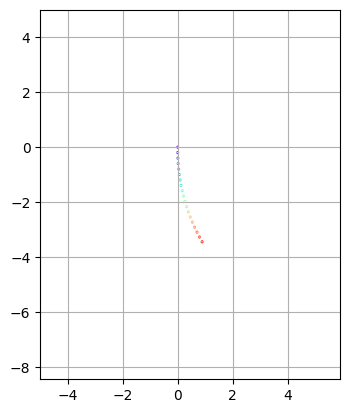

In [102]:
x0 = np.zeros(3, dtype=np.float64)
x0[2] = np.pi / 2
v0 = -2.
mpc = basic_mpc()
time_grid = np.arange(0, 2, 0.1)
control = np.zeros((n_steps, 2), dtype=np.float64)
control[:, 1] = -0.6
pp, pv, _,  _ = predict_path(x0, v0, control, time_grid, time_grid[1] - time_grid[0])

plot_traj(pp)

3.9269908169872414
optimization time:  0.889568567276001
[10.         0.5999999]
cost:  170.06039800643512
----------


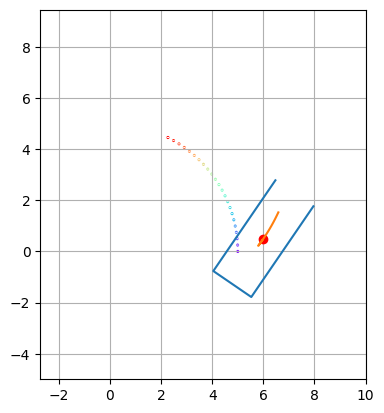

In [101]:
angles = np.arange(0, np.pi/2 - 0.4, 0.05)
r = 5.
xs = np.cos(angles) * r
ys = np.sin(angles) * r
traj = np.stack((xs, ys, angles), axis=1)

x0 = np.array([6., 0.5, np.pi/2-0.6])
plot_car(x0)
plot_traj(traj[:, :2])
mpc = basic_mpc()
timestamps = np.linspace(0, np.pi * r / 4, len(traj))
mpc.n_steps = len(traj)
mpc.immediate_timestamps = timestamps
mpc.lookahead = np.pi * r / 4
print(mpc.lookahead)
pp = mpc.optimize_control_MPC(x0, -0.5, traj)
pp = np.array(pp)
plt.plot(pp[:, 0], pp[:, 1])